# Seq2Seq 모델

In [14]:
import pandas as pd
import seaborn as sns
import pandas_profiling
from matplotlib import pyplot as plt
import numpy as np
from sklearn import preprocessing

pd.set_option('display.max_row', 500)
pd.set_option('display.max_columns', 100)

df = pd.read_csv('train/train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52560 entries, 0 to 52559
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Day     52560 non-null  int64  
 1   Hour    52560 non-null  int64  
 2   Minute  52560 non-null  int64  
 3   DHI     52560 non-null  int64  
 4   DNI     52560 non-null  int64  
 5   WS      52560 non-null  float64
 6   RH      52560 non-null  float64
 7   T       52560 non-null  int64  
 8   TARGET  52560 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 3.6 MB


In [15]:
df['Minute'].replace(30, 0.5, inplace=True)
df['Time'] = df['Hour'] + df['Minute']
df = df.drop(['Hour', 'Minute'], axis=1)

In [16]:
# 하루 48 -> 29
df_none_zero = df[(df['Time'] >= 5.0) & (df['Time'] <= 19.0)]
df_none_zero.reset_index(drop=True, inplace=True)

In [17]:
df_none_zero['Origin_TARGET'] = df_none_zero['TARGET'].copy()

normalize_target_column = ['DHI', 'DNI', 'WS','RH','T', 'Time', 'TARGET']

for c in normalize_target_column:
    x = df_none_zero[[c]].copy() #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_none_zero[c] = x_scaled

df_agg = df_none_zero.groupby('Day').agg({
    # DHI, DNI의 min 값은 모두 0, 매일 29개의 row 중 빛이 없는 경우는 반드시 있으므로
    # 따라서 DHI, DNI의 min은 제외
    'DHI': ['mean','max','std','var','sum','median'],
    'DNI': ['mean','max','std','var','sum','median'],
    'WS': ['mean','min','max','std','var','sum','median'],
    'RH': ['mean','min','max','std','var','sum','median'],
    'T': ['mean','min','max','std','var','sum','median'],
})

df_agg.columns = [('_').join(column) for column in df_agg.columns.ravel()]
df_agg = df_agg.reset_index(drop=True)
df_agg['Day_length'] = df_none_zero[df_none_zero['TARGET'] != 0.0].groupby('Day')['Time'].count()
df_agg['Day_length'] /= df_agg['Day_length'].max()
df_agg.head(10)

C:\Users\qkrwl\anaconda3\envs\kaggle\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\qkrwl\anaconda3\envs\kaggle\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\qkrwl\anaconda3\envs\kaggle\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

,DHI_mean,DHI_max,DHI_std,DHI_var,DHI_sum,DHI_median,DNI_mean,DNI_max,DNI_std,DNI_var,DNI_sum,DNI_median,WS_mean,WS_min,WS_max,WS_std,WS_var,WS_sum,WS_median,RH_mean,RH_min,RH_max,RH_std,RH_var,RH_sum,RH_median,T_mean,T_min,T_max,T_std,T_var,T_sum,T_median,Day_length
0,0.140870,0.403409,0.152041,0.023117,4.085227,0.109848,0.123018,0.765817,0.210889,0.044474,3.567517,0.006610,0.175000,0.108333,0.266667,0.044208,0.001954,5.075000,0.166667,0.629918,0.493020,0.748079,0.077597,0.006021,18.267612,0.626123,0.231801,0.129630,0.296296,0.057211,0.003273,6.722222,0.240741,0.62069
1,0.058320,0.126894,0.052898,0.002798,1.691288,0.053030,0.461366,0.925401,0.414326,0.171666,13.379603,0.605288,0.133908,0.033333,0.275000,0.065197,0.004251,3.883333,0.133333,0.663512,0.499838,0.863002,0.111521,0.012437,19.241857,0.663565,0.275223,0.129630,0.388889,0.088912,0.007905,7.981481,0.296296,0.62069
2,0.090713,0.333333,0.101894,0.010382,2.630682,0.053030,0.038520,0.505194,0.116973,0.013683,1.117092,0.000000,0.256609,0.125000,0.441667,0.096886,0.009387,7.441667,0.216667,0.745624,0.605454,0.860946,0.074585,0.005563,21.623093,0.740180,0.272031,0.148148,0.351852,0.066788,0.004461,7.888889,0.277778,0.62069
3,0.123237,0.399621,0.134937,0.018208,3.573864,0.064394,0.104686,0.860246,0.189817,0.036031,3.035883,0.000000,0.208333,0.125000,0.300000,0.049950,0.002495,6.041667,0.200000,0.583916,0.448977,0.703820,0.068998,0.004761,16.933557,0.614327,0.284802,0.129630,0.370370,0.079252,0.006281,8.259259,0.314815,0.62069
4,0.138323,0.412879,0.147664,0.021805,4.011364,0.083333,0.035167,0.207743,0.062211,0.003870,1.019830,0.000000,0.450862,0.191667,0.666667,0.152449,0.023241,13.075000,0.450000,0.695883,0.615951,0.807813,0.058321,0.003401,20.180608,0.695163,0.398467,0.277778,0.462963,0.055251,0.003053,11.555556,0.407407,0.62069
5,0.113310,0.297348,0.104975,0.011020,3.285985,0.104167,0.253101,0.702550,0.258811,0.066983,7.339943,0.221907,0.229598,0.158333,0.283333,0.040495,0.001640,6.658333,0.225000,0.755553,0.570826,0.956931,0.113119,0.012796,21.911049,0.777946,0.428480,0.351852,0.518519,0.064857,0.004206,12.425926,0.407407,0.62069
6,0.115596,0.412879,0.142529,0.020315,3.352273,0.070076,0.125330,0.823418,0.254324,0.064681,3.634561,0.000000,0.107471,0.075000,0.250000,0.043777,0.001916,3.116667,0.091667,0.693573,0.539552,0.855319,0.103570,0.010727,20.113624,0.694730,0.328863,0.240741,0.407407,0.053226,0.002833,9.537037,0.333333,0.62069
7,0.061259,0.128788,0.053853,0.002900,1.776515,0.068182,0.488262,0.915014,0.407502,0.166058,14.159585,0.685552,0.226724,0.108333,0.383333,0.092297,0.008519,6.575000,0.191667,0.676069,0.476031,1.000000,0.169303,0.028664,19.605995,0.608268,0.415709,0.314815,0.500000,0.065582,0.004301,12.055556,0.407407,0.62069
8,0.135906,0.424242,0.154905,0.023996,3.941288,0.083333,0.244733,0.861190,0.306095,0.093694,7.097262,0.083097,0.112644,0.041667,0.175000,0.030344,0.000921,3.266667,0.116667,0.684106,0.541067,0.847419,0.105450,0.011120,19.839087,0.715832,0.337803,0.222222,0.425926,0.067437,0.004548,9.796296,0.351852,0.62069
9,0.085031,0.202652,0.076803,0.005899,2.465909,0.094697,0.389502,0.883853,0.354802,0.125885,11.295562,0.331445,0.191379,0.025000,0.316667,0.100136,0.010027,5.550000,0.250000,0.653758,0.457202,0.830971,0.118677,0.014084,18.958987,0.671789,0.419540,0.333333,0.518519,0.065711,0.004318,12.166667,0.407407,0.62069


In [18]:
df_agg

,DHI_mean,DHI_max,DHI_std,DHI_var,DHI_sum,DHI_median,DNI_mean,DNI_max,DNI_std,DNI_var,DNI_sum,DNI_median,WS_mean,WS_min,WS_max,WS_std,WS_var,WS_sum,WS_median,RH_mean,RH_min,RH_max,RH_std,RH_var,RH_sum,RH_median,T_mean,T_min,T_max,T_std,T_var,T_sum,T_median,Day_length
0,0.140870,0.403409,0.152041,0.023117,4.085227,0.109848,0.123018,0.765817,0.210889,0.044474,3.567517,0.006610,0.175000,0.108333,0.266667,0.044208,0.001954,5.075000,0.166667,0.629918,0.493020,0.748079,0.077597,0.006021,18.267612,0.626123,0.231801,0.129630,0.296296,0.057211,0.003273,6.722222,0.240741,0.62069
1,0.058320,0.126894,0.052898,0.002798,1.691288,0.053030,0.461366,0.925401,0.414326,0.171666,13.379603,0.605288,0.133908,0.033333,0.275000,0.065197,0.004251,3.883333,0.133333,0.663512,0.499838,0.863002,0.111521,0.012437,19.241857,0.663565,0.275223,0.129630,0.388889,0.088912,0.007905,7.981481,0.296296,0.62069
2,0.090713,0.333333,0.101894,0.010382,2.630682,0.053030,0.038520,0.505194,0.116973,0.013683,1.117092,0.000000,0.256609,0.125000,0.441667,0.096886,0.009387,7.441667,0.216667,0.745624,0.605454,0.860946,0.074585,0.005563,21.623093,0.740180,0.272031,0.148148,0.351852,0.066788,0.004461,7.888889,0.277778,0.62069
3,0.123237,0.399621,0.134937,0.018208,3.573864,0.064394,0.104686,0.860246,0.189817,0.036031,3.035883,0.000000,0.208333,0.125000,0.300000,0.049950,0.002495,6.041667,0.200000,0.583916,0.448977,0.703820,0.068998,0.004761,16.933557,0.614327,0.284802,0.129630,0.370370,0.079252,0.006281,8.259259,0.314815,0.62069
4,0.138323,0.412879,0.147664,0.021805,4.011364,0.083333,0.035167,0.207743,0.062211,0.003870,1.019830,0.000000,0.450862,0.191667,0.666667,0.152449,0.023241,13.075000,0.450000,0.695883,0.615951,0.807813,0.058321,0.003401,20.180608,0.695163,0.398467,0.277778,0.462963,0.055251,0.003053,11.555556,0.407407,0.62069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090,0.058712,0.130682,0.053209,0.002831,1.702652,0.064394,0.478949,0.923513,0.406235,0.165027,13.889518,0.654391,0.270115,0.141667,0.391667,0.070271,0.004938,7.833333,0.258333,0.502767,0.372687,0.595282,0.073293,0.005372,14.580240,0.536847,0.371648,0.259259,0.462963,0.063175,0.003991,10.777778,0.351852,0.62069
1091,0.093521,0.257576,0.089891,0.008080,2.712121,0.083333,0.322881,0.744098,0.287719,0.082782,9.363551,0.435316,0.122414,0.041667,0.250000,0.042789,0.001831,3.550000,0.116667,0.512301,0.357862,0.717022,0.115103,0.013249,14.856725,0.484471,0.385696,0.333333,0.481481,0.052860,0.002794,11.185185,0.370370,0.62069
1092,0.108346,0.350379,0.108488,0.011770,3.142045,0.102273,0.267722,0.812087,0.263637,0.069505,7.763928,0.307838,0.276724,0.075000,0.458333,0.139965,0.019590,8.025000,0.333333,0.428275,0.353533,0.546911,0.054368,0.002956,12.419976,0.415215,0.425926,0.351852,0.518519,0.063382,0.004017,12.351852,0.407407,0.62069
1093,0.052377,0.164773,0.047962,0.002300,1.518939,0.064394,0.484224,0.933900,0.405847,0.164711,14.042493,0.693107,0.302299,0.216667,0.408333,0.080975,0.006557,8.766667,0.291667,0.373030,0.229737,0.506439,0.072695,0.005285,10.817877,0.388161,0.427842,0.333333,0.537037,0.070750,0.005006,12.407407,0.425926,0.62069


## Model Praparation

In [19]:
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Input, concatenate, Dropout, BatchNormalization, PReLU
from keras.layers import Flatten, Concatenate
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras import Model
from keras import backend as K
import tensorflow as tf
from keras import optimizers

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

# 7일의 데이터로 2일을 예측
# 1일 = 48개의 관측값
# 7일 = 7 * 48 = 336
# 2일 = 2 * 48 = 96
def pinball_loss(tau):
    def loss(y_true, y_pred):
        err = y_true - y_pred
        return K.mean(K.maximum(tau * err, (tau - 1) * err), axis=-1)
    return loss


opt = optimizers.RMSprop()

latent_dim = 128

encoder_inputs = Input(shape=(29*7, 6), name='encoder_inputs')
encoder = LSTM(latent_dim, return_state=True, name='encoder_lstm')
encoder_outputs, encoder_state_h, encoder_state_c = encoder(encoder_inputs)
# `encoder_outputs`는 버리고 상태(`state_h, state_c`)는 유지
encoder_states = [encoder_state_h, encoder_state_c]

# `encoder_states`를 초기 상태로 사용해 decoder를 설정
decoder_inputs = Input(shape=(96, 1))
decoder_inputs_sequence = Input(shape=(96, 96))
decoder_inputs_agg = Input(shape=(96, 34*7))
# 전체 출력 시퀀스를 반환하고 내부 상태도 반환하도록 decoder를 설정. 
# 학습 모델에서 상태를 반환하도록 하진 않지만, inference에서 사용할 예정.
decoder_lstm_1 = LSTM(latent_dim, return_sequences=True, return_state=True, name='decoder_lstm_1')
decoder_outputs, _, _ = decoder_lstm_1(decoder_inputs, initial_state=encoder_states)
decoder_lstm_2 = LSTM(latent_dim, return_sequences=True, return_state=True, name='decoder_lstm_2')
decoder_outputs, _, _ = decoder_lstm_2(decoder_outputs, initial_state=encoder_states)
decoder_lstm_3 = LSTM(latent_dim, return_sequences=True, return_state=True, name='decoder_lstm_3')
decoder_outputs, _, _ = decoder_lstm_3(decoder_outputs, initial_state=encoder_states)

concat_inputs = Concatenate()
concat_time_inputs = concat_inputs([decoder_outputs, decoder_inputs_sequence, decoder_inputs_agg])

decoder_dense_1 = Dense(256)
decoder_dense_2 = Dense(128)
decoder_dense_3 = Dense(96)

decoder_outputs = decoder_time_dense_1(concat_time_inputs)
decoder_outputs = decoder_time_dense_2(decoder_outputs)
decoder_outputs = decoder_time_dense_3(decoder_outputs)


# `encoder_input_data`와 `decoder_input_data`를 `decoder_target_data`로 반환하도록 모델을 정의
main_model = Model([encoder_inputs, decoder_inputs, decoder_inputs_sequence, decoder_inputs_agg], decoder_outputs)
main_model.compile(loss='MSE', optimizer=opt)
main_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, 203, 6)]     0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 96, 1)]      0                                            
__________________________________________________________________________________________________
encoder_lstm (LSTM)             [(None, 128), (None, 69120       encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_lstm_1 (LSTM)           [(None, 96, 128), (N 66560       input_4[0][0]                    
                                                                 encoder_lstm[0][1]    

In [20]:
def make_train_data_set(df_none_zero, df_agg, ins_day=7, outs_day=2):
    df_none_zero = df_none_zero.astype('float')
    df_datas = df_none_zero.drop(columns=['Day', 'Origin_TARGET', 'Time']).values
    df_agg_datas = df_agg.values
    outs_datas = df[['TARGET']].values
    
    ins = []
    outs = []
    
    term_per_day = 29
    
    for i in range(len(df_agg)-(ins_day + outs_day)):
        encoder_ins_df = df_datas[i*term_per_day:(i+ins_day)*term_per_day]
        decoder_outs_df = outs_datas[(i+ins_day)*48:(i+ins_day+outs_day)*48]
        decoder_ins_df = np.concatenate(([0], decoder_outs_df[:-1].flatten())).reshape((96, 1))
        df_agg_data = df_agg_datas[i:i+7]
        ins_df_agg = np.repeat(df_agg_data.reshape(1,34*7), 96, axis=0)
        
        ins.append([encoder_ins_df, decoder_ins_df, ins_df_agg])
        outs.append(decoder_outs_df)
        
    return np.array(ins), np.array(outs)

ins, outs = make_train_data_set(df_none_zero, df_agg, ins_day=7)
print(ins.shape, outs.shape)
print(ins[0][0].shape, ins[0][1].shape, ins[0][2].shape)

(1086, 3) (1086, 96, 1)
(203, 6) (96, 1) (96, 238)


In [21]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(ins, outs, test_size=0.2, shuffle=False)

In [22]:
x_train_encoder = np.array([l for l in x_train[:,0]])
x_train_decoder = np.array([l.flatten() for l in x_train[:,1]])
x_train_agg = np.array([l for l in x_train[:,2]])

x_test_encoder = np.array([l for l in x_test[:,0]])
x_test_decoder = np.array([l.flatten() for l in x_test[:,1]])
x_test_agg = np.array([l for l in x_test[:,2]])

In [23]:
sequence_vector = np.array([[0.0] * 96 for _ in range(96)])
for i in range(96):
    sequence_vector[i, i] = 1.0

print(sequence_vector.shape)
train_sequence_vector = np.repeat([sequence_vector], 868, axis=0)
print(train_sequence_vector.shape)

test_sequence_vector = np.repeat([sequence_vector], 218, axis=0)
print(test_sequence_vector.shape)

(96, 96)
(868, 96, 96)
(218, 96, 96)


In [24]:
print(x_train_encoder.shape, x_train_decoder.shape, train_sequence_vector.shape, x_train_agg.shape)
print(x_test_encoder.shape, x_test_decoder.shape, test_sequence_vector.shape, x_test_agg.shape)

(868, 203, 6) (868, 96) (868, 96, 96) (868, 96, 238)
(218, 203, 6) (218, 96) (218, 96, 96) (218, 96, 238)


In [25]:
%%time

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint


print(f'#### Model ####')
his = main_model.fit([x_train_encoder, x_train_decoder, train_sequence_vector, x_train_agg], y_train, epochs=500, batch_size=300, 
                     validation_data=([x_test_encoder, x_test_decoder, test_sequence_vector, x_test_agg], y_test), verbose=1)


#### Model ####
Epoch 1/500
3/3 [==============================] - 1s 349ms/step - loss: 698.9387 - val_loss: 535.6698
Epoch 2/500
3/3 [==============================] - 0s 89ms/step - loss: 421.7028 - val_loss: 436.8985
Epoch 3/500
3/3 [==============================] - 0s 89ms/step - loss: 403.7596 - val_loss: 323.1550
Epoch 4/500
3/3 [==============================] - 0s 109ms/step - loss: 253.2201 - val_loss: 169.9273
Epoch 5/500
3/3 [==============================] - 0s 120ms/step - loss: 171.6581 - val_loss: 255.8131
Epoch 6/500


KeyboardInterrupt: 

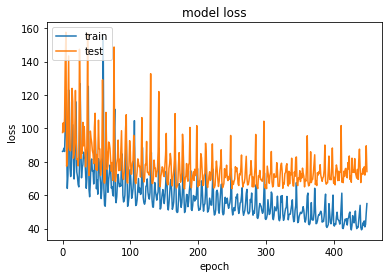

In [13]:
plt.plot(his.history['loss'][50:])
plt.plot(his.history['val_loss'][50:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Decoder Model Preparation

In [15]:
encoder_model = Model(encoder_inputs, encoder_states)

pre_decoder_inputs = Input(shape=(1, 1))
pre_decoder_state_input_h_1 = Input(shape=(latent_dim,))
pre_decoder_state_input_c_1 = Input(shape=(latent_dim,))
pre_decoder_state_input_h_2 = Input(shape=(latent_dim,))
pre_decoder_state_input_c_2 = Input(shape=(latent_dim,))
pre_decoder_state_input_h_3 = Input(shape=(latent_dim,))
pre_decoder_state_input_c_3 = Input(shape=(latent_dim,))

pre_decoder_states_inputs = [
    pre_decoder_state_input_h_1, pre_decoder_state_input_c_1,
    pre_decoder_state_input_h_2, pre_decoder_state_input_c_2,
    pre_decoder_state_input_h_3, pre_decoder_state_input_c_3,
]

pre_decoder_lstm_1 = LSTM(latent_dim, return_sequences=True, return_state=True, name='pre_decoder_lstm_1')
pre_decoder_lstm_2 = LSTM(latent_dim, return_sequences=True, return_state=True, name='pre_decoder_lstm_2')
pre_decoder_lstm_3 = LSTM(latent_dim, return_sequences=False, return_state=True, name='pre_decoder_lstm_3')

pre_decoder_outputs, pre_decoder_state_h_1, pre_decoder_state_c_1 = pre_decoder_lstm_1(pre_decoder_inputs, initial_state=pre_decoder_states_inputs[:2])
pre_decoder_outputs, pre_decoder_state_h_2, pre_decoder_state_c_2 = pre_decoder_lstm_2(pre_decoder_outputs, initial_state=pre_decoder_states_inputs[2:4])
pre_decoder_outputs, pre_decoder_state_h_3, pre_decoder_state_c_3 = pre_decoder_lstm_3(pre_decoder_outputs, initial_state=pre_decoder_states_inputs[4:])

pre_decoder_states = [
    pre_decoder_state_h_1, pre_decoder_state_c_1,
    pre_decoder_state_h_2, pre_decoder_state_c_2,
    pre_decoder_state_h_3, pre_decoder_state_c_3,
]

pre_decoder_inputs_sequence = Input(shape=(96, ), name='pre_decoder_inputs_sequence')


pre_concat_inputs = Concatenate()
pre_concat_time_inputs = pre_concat_inputs([pre_decoder_outputs, pre_decoder_inputs_sequence])

pre_decoder_outputs = decoder_dense(pre_concat_time_inputs)
# decoder_outputs = fine_decoder_dense_2(decoder_outputs)
# decoder_outputs = fine_decoder_dense_3(decoder_outputs)

decoder_model = Model(
    [pre_decoder_inputs, pre_decoder_inputs_sequence] + pre_decoder_states_inputs,
    [pre_decoder_outputs] + pre_decoder_states
)

decoder_model.summary()

decoder_model.get_layer('pre_decoder_lstm_1').set_weights(main_model.get_layer('decoder_lstm_1').get_weights())
decoder_model.get_layer('pre_decoder_lstm_2').set_weights(main_model.get_layer('decoder_lstm_2').get_weights())
decoder_model.get_layer('pre_decoder_lstm_3').set_weights(main_model.get_layer('decoder_lstm_3').get_weights())
# decoder_model.get_layer('last_dense_1').set_weights(fine_model.get_layer('time_dense_1').get_weights())
# decoder_model.get_layer('last_dense_2').set_weights(fine_model.get_layer('time_dense_2').get_weights())
# decoder_model.get_layer('last_dense_3').set_weights(fine_model.get_layer('time_dense_3').get_weights())
# decoder_model.get_layer('pre_decoder_lstm_2').set_weights(main_model.get_layer('decoder_lstm_2').get_weights())
# decoder_model.get_layer('pre_decoder_lstm_3').set_weights(main_model.get_layer('decoder_lstm_3').get_weights())

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1, 1)]       0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
pre_decoder_lstm_1 (LSTM)       [(None, 1, 128), (No 66560       input_5[0][0]                    
                                                                 input_6[0][0]         

In [17]:
def decode_sequence(input_seq):
    # 상태 벡터로서 입력값을 encode
    states_value = encoder_model.predict(input_seq)
    result = []

    target_seq = np.zeros((1, 1, 1))
    target_seq[0, 0, 0] = 0.0
    
    for i in range(96):
        output, h1, c1, h2, c2, h3, c3 = decoder_model.predict([target_seq, sequence_vector[i].reshape((1, 96))] + states_value*3)
        
        
        # 토큰으로 샘플링
        target_out = output[0, 0]
#         print(output)
        result.append(target_out)

        # (길이 1인) 목표 시퀀스 최신화
        target_seq = np.zeros((1, 1, 1))
        target_seq[0, 0, 0] = target_out

        # 상태 최신화
        states_value = [h1, c1, h2, c2, h3, c3]
        
    return result

In [20]:
opt = optimizers.Adam()

fine_decoder_inputs = Input(shape=(96, 1))
fine_decoder_inputs_sequence = Input(shape=(96, 96))

decoder_outputs, _, _ = decoder_lstm_1(fine_decoder_inputs, initial_state=encoder_states)
decoder_outputs, _, _ = decoder_lstm_2(decoder_outputs, initial_state=encoder_states)
decoder_outputs, _, _ = decoder_lstm_3(decoder_outputs, initial_state=encoder_states)

concat_time_inputs = concat_inputs([decoder_outputs, fine_decoder_inputs_sequence])

fine_decoder_dense_1 = Dense(150, name='dense_1')
decoder_time_dense_1 = TimeDistributed(fine_decoder_dense_1, name='time_dense_1')

fine_decoder_dense_2 = Dense(100, name='dense_2')
decoder_time_dense_2 = TimeDistributed(fine_decoder_dense_2, name='time_dense_2')

fine_decoder_dense_3 = Dense(1, name='dense_3', activation='linear')
decoder_time_dense_3 = TimeDistributed(fine_decoder_dense_3, name='time_dense_3')


decoder_outputs = decoder_time_dense_1(concat_time_inputs)
decoder_outputs = decoder_time_dense_2(decoder_outputs)
decoder_outputs = decoder_time_dense_3(decoder_outputs)

# `encoder_input_data`와 `decoder_input_data`를 `decoder_target_data`로 반환하도록 모델을 정의
fine_model = Model([encoder_inputs, fine_decoder_inputs, fine_decoder_inputs_sequence], decoder_outputs)
fine_model.compile(loss='MSE', optimizer=opt)

#     model.compile(loss=pinball_loss(tau), optimizer=opt)
# if use_mse:

# fine_main_model.get_layer('fine_decoder_lstm_1').set_weights(main_model.get_layer('decoder_lstm_1').get_weights())
fine_model.get_layer('decoder_lstm_1').trainable=False
fine_model.get_layer('decoder_lstm_2').trainable=False
fine_model.get_layer('decoder_lstm_3').trainable=False
fine_model.get_layer('encoder_lstm').trainable=False

fine_model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, 203, 6)]     0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 96, 1)]      0                                            
__________________________________________________________________________________________________
encoder_lstm (LSTM)             [(None, 128), (None, 69120       encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_lstm_1 (LSTM)           [(None, 96, 128), (N 66560       input_14[0][0]                   
                                                                 encoder_lstm[0][1]    

In [21]:
print(f'#### Model ####')
his = fine_model.fit([x_train_encoder, x_train_decoder, train_sequence_vector], y_train, epochs=100, batch_size=300, 
#                       verbose=1)
                     validation_data=([x_test_encoder, x_test_decoder, test_sequence_vector], y_test), verbose=1)

#### Model ####
Epoch 1/100
3/3 [==============================] - 1s 240ms/step - loss: 852.0349 - val_loss: 701.9185
Epoch 2/100
3/3 [==============================] - 0s 26ms/step - loss: 613.8353 - val_loss: 465.3910
Epoch 3/100
3/3 [==============================] - 0s 26ms/step - loss: 379.3287 - val_loss: 252.5028
Epoch 4/100
3/3 [==============================] - 0s 26ms/step - loss: 184.4000 - val_loss: 115.1856
Epoch 5/100
3/3 [==============================] - 0s 21ms/step - loss: 83.5545 - val_loss: 108.4548
Epoch 6/100
3/3 [==============================] - 0s 21ms/step - loss: 102.4783 - val_loss: 163.6601
Epoch 7/100
3/3 [==============================] - 0s 21ms/step - loss: 135.4930 - val_loss: 147.5782
Epoch 8/100
3/3 [==============================] - 0s 21ms/step - loss: 103.0780 - val_loss: 96.2706
Epoch 9/100
3/3 [==============================] - 0s 26ms/step - loss: 61.8093 - val_loss: 73.2529
Epoch 10/100
3/3 [==============================] - 0s 26ms/step - lo

In [23]:
encoder_model = Model(encoder_inputs, encoder_states)

pre_decoder_inputs = Input(shape=(1, 1))
pre_decoder_state_input_h_1 = Input(shape=(latent_dim,))
pre_decoder_state_input_c_1 = Input(shape=(latent_dim,))
pre_decoder_state_input_h_2 = Input(shape=(latent_dim,))
pre_decoder_state_input_c_2 = Input(shape=(latent_dim,))
pre_decoder_state_input_h_3 = Input(shape=(latent_dim,))
pre_decoder_state_input_c_3 = Input(shape=(latent_dim,))

pre_decoder_states_inputs = [
    pre_decoder_state_input_h_1, pre_decoder_state_input_c_1,
    pre_decoder_state_input_h_2, pre_decoder_state_input_c_2,
    pre_decoder_state_input_h_3, pre_decoder_state_input_c_3,
]

pre_decoder_lstm_1 = LSTM(latent_dim, return_sequences=True, return_state=True, name='pre_decoder_lstm_1')
pre_decoder_lstm_2 = LSTM(latent_dim, return_sequences=True, return_state=True, name='pre_decoder_lstm_2')
pre_decoder_lstm_3 = LSTM(latent_dim, return_sequences=False, return_state=True, name='pre_decoder_lstm_3')

pre_decoder_outputs, pre_decoder_state_h_1, pre_decoder_state_c_1 = pre_decoder_lstm_1(pre_decoder_inputs, initial_state=pre_decoder_states_inputs[:2])
pre_decoder_outputs, pre_decoder_state_h_2, pre_decoder_state_c_2 = pre_decoder_lstm_2(pre_decoder_outputs, initial_state=pre_decoder_states_inputs[2:4])
pre_decoder_outputs, pre_decoder_state_h_3, pre_decoder_state_c_3 = pre_decoder_lstm_3(pre_decoder_outputs, initial_state=pre_decoder_states_inputs[4:])

pre_decoder_states = [
    pre_decoder_state_h_1, pre_decoder_state_c_1,
    pre_decoder_state_h_2, pre_decoder_state_c_2,
    pre_decoder_state_h_3, pre_decoder_state_c_3,
]

pre_decoder_inputs_sequence = Input(shape=(96, ), name='pre_decoder_inputs_sequence')


pre_concat_inputs = Concatenate()
pre_concat_time_inputs = pre_concat_inputs([pre_decoder_outputs, pre_decoder_inputs_sequence])

pre_decoder_outputs = fine_decoder_dense_1(pre_concat_time_inputs)
pre_decoder_outputs = fine_decoder_dense_2(pre_decoder_outputs)
pre_decoder_outputs = fine_decoder_dense_3(pre_decoder_outputs)

decoder_model = Model(
    [pre_decoder_inputs, pre_decoder_inputs_sequence] + pre_decoder_states_inputs,
    [pre_decoder_outputs] + pre_decoder_states
)

decoder_model.get_layer('pre_decoder_lstm_1').set_weights(main_model.get_layer('decoder_lstm_1').get_weights())
decoder_model.get_layer('pre_decoder_lstm_2').set_weights(main_model.get_layer('decoder_lstm_2').get_weights())
decoder_model.get_layer('pre_decoder_lstm_3').set_weights(main_model.get_layer('decoder_lstm_3').get_weights())

decoder_model.summary()
# decoder_model.get_layer('last_dense_1').set_weights(fine_model.get_layer('time_dense_1').get_weights())
# decoder_model.get_layer('last_dense_2').set_weights(fine_model.get_layer('time_dense_2').get_weights())
# decoder_model.get_layer('last_dense_3').set_weights(fine_model.get_layer('time_dense_3').get_weights())
# decoder_model.get_layer('pre_decoder_lstm_2').set_weights(main_model.get_layer('decoder_lstm_2').get_weights())
# decoder_model.get_layer('pre_decoder_lstm_3').set_weights(main_model.get_layer('decoder_lstm_3').get_weights())

Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 1, 1)]       0                                            
__________________________________________________________________________________________________
input_24 (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_25 (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
pre_decoder_lstm_1 (LSTM)       [(None, 1, 128), (No 66560       input_23[0][0]                   
                                                                 input_24[0][0]       